In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# LOADING THE DATASET

In [150]:
train_df=pd.read_csv("train_trafficpattern.csv")
df_train=train_df.copy()
df_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [151]:
test_df=pd.read_csv("test_trafficpattern.csv")
df_test=test_df.copy()
df_test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [152]:
print(df_train.shape)

(48120, 4)


In [153]:
print(df_test.shape)

(11808, 3)


# SEARCHING FOR NULL VALUES

In [154]:
df_train.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [155]:
df_test.isnull().sum()

DateTime    0
Junction    0
ID          0
dtype: int64

In [156]:
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])  
df_train['day_of_week'] = df_train['DateTime'].dt.dayofweek  
df_train['month'] = df_train['DateTime'].dt.month  
df_train['hour'] = df_train['DateTime'].dt.hour  
df_train['day'] = df_train['DateTime'].dt.day  
df_train['year'] = df_train['DateTime'].dt.year  
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype(int)
df_train['is_business_hours'] = df_train['hour'].between(8, 17).astype(int)
df_train = pd.get_dummies(df_train, columns=['Junction'], prefix=['Junction'])
print(df_train.head())

             DateTime  Vehicles           ID  day_of_week  month  hour  day  \
0 2015-11-01 00:00:00        15  20151101001            6     11     0    1   
1 2015-11-01 01:00:00        13  20151101011            6     11     1    1   
2 2015-11-01 02:00:00        10  20151101021            6     11     2    1   
3 2015-11-01 03:00:00         7  20151101031            6     11     3    1   
4 2015-11-01 04:00:00         9  20151101041            6     11     4    1   

   year  is_weekend  is_business_hours  Junction_1  Junction_2  Junction_3  \
0  2015           1                  0           1           0           0   
1  2015           1                  0           1           0           0   
2  2015           1                  0           1           0           0   
3  2015           1                  0           1           0           0   
4  2015           1                  0           1           0           0   

   Junction_4  
0           0  
1           0  
2       

In [157]:
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])  
df_test['day_of_week'] = df_test['DateTime'].dt.dayofweek  
df_test['month'] = df_test['DateTime'].dt.month  
df_test['hour'] = df_test['DateTime'].dt.hour  
df_test['day'] = df_test['DateTime'].dt.day  
df_test['year'] = df_test['DateTime'].dt.year  
df_test['is_weekend'] = df_test['day_of_week'].isin([5, 6]).astype(int)
df_test['is_business_hours'] = df_test['hour'].between(8, 17).astype(int)
df_test = pd.get_dummies(df_test,columns=['Junction'], prefix=['Junction'])
print(df_test.head())

             DateTime           ID  day_of_week  month  hour  day  year  \
0 2017-07-01 00:00:00  20170701001            5      7     0    1  2017   
1 2017-07-01 01:00:00  20170701011            5      7     1    1  2017   
2 2017-07-01 02:00:00  20170701021            5      7     2    1  2017   
3 2017-07-01 03:00:00  20170701031            5      7     3    1  2017   
4 2017-07-01 04:00:00  20170701041            5      7     4    1  2017   

   is_weekend  is_business_hours  Junction_1  Junction_2  Junction_3  \
0           1                  0           1           0           0   
1           1                  0           1           0           0   
2           1                  0           1           0           0   
3           1                  0           1           0           0   
4           1                  0           1           0           0   

   Junction_4  
0           0  
1           0  
2           0  
3           0  
4           0  


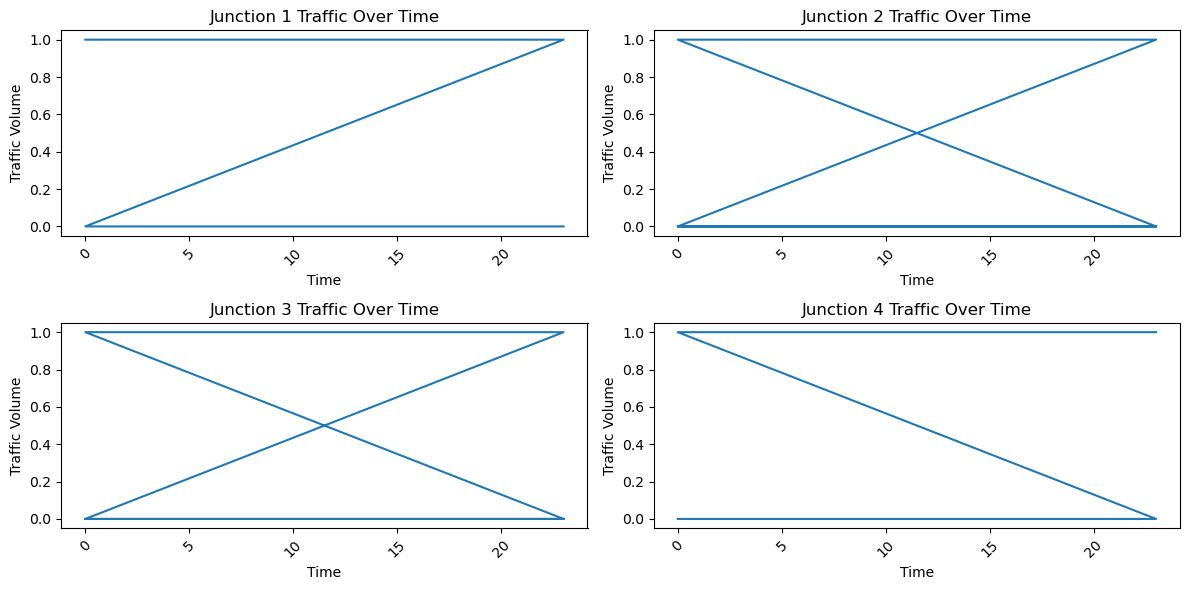

In [158]:
import matplotlib.pyplot as plt

junction_columns = ['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4']

plt.figure(figsize=(12, 6))

for idx, column_name in enumerate(junction_columns, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(df_train['hour'], df_train[column_name])
    plt.title(f'Junction {idx} Traffic Over Time')
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


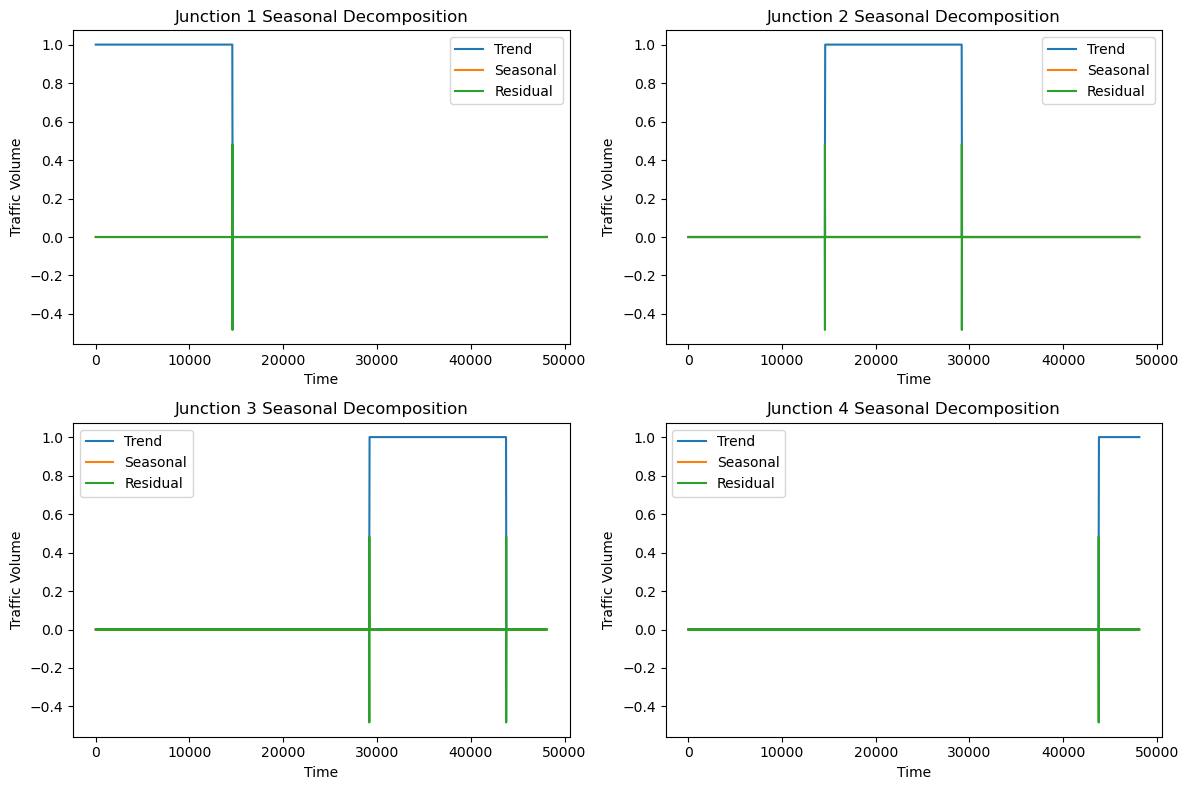

In [159]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

junction_columns = ['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4']

plt.figure(figsize=(12, 8))

for idx, column_name in enumerate(junction_columns, start=1):
    plt.subplot(2, 2, idx)
    junction_data = df_train[column_name]
    result = seasonal_decompose(junction_data, model='additive', period=30)  # Specify the seasonality with 'period'
    plt.plot(result.trend, label='Trend')
    plt.plot(result.seasonal, label='Seasonal')
    plt.plot(result.resid, label='Residual')
    plt.title(f'Junction {idx} Seasonal Decomposition')
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.legend()

plt.tight_layout()
plt.show()


# logistic Regression

In [160]:
threshold_value = 100  
df_train['congested'] = (df_train['Vehicles'] > threshold_value).astype(int)


In [161]:

X = df_train[['Vehicles', 'day_of_week']]
y = df_train['congested']


In [162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [163]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [164]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 1.0
Confusion Matrix:
[[9575    0]
 [   0   49]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9575
           1       1.00      1.00      1.00        49

    accuracy                           1.00      9624
   macro avg       1.00      1.00      1.00      9624
weighted avg       1.00      1.00      1.00      9624



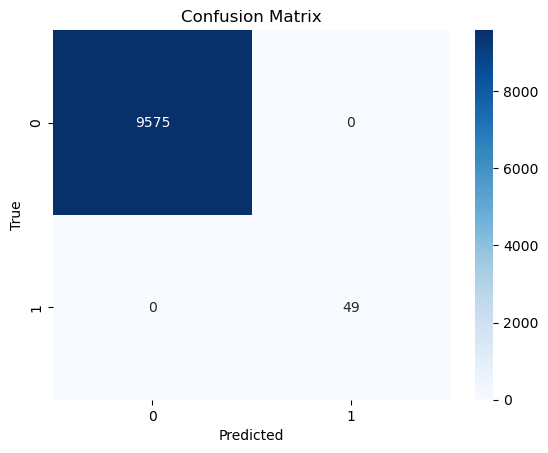

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


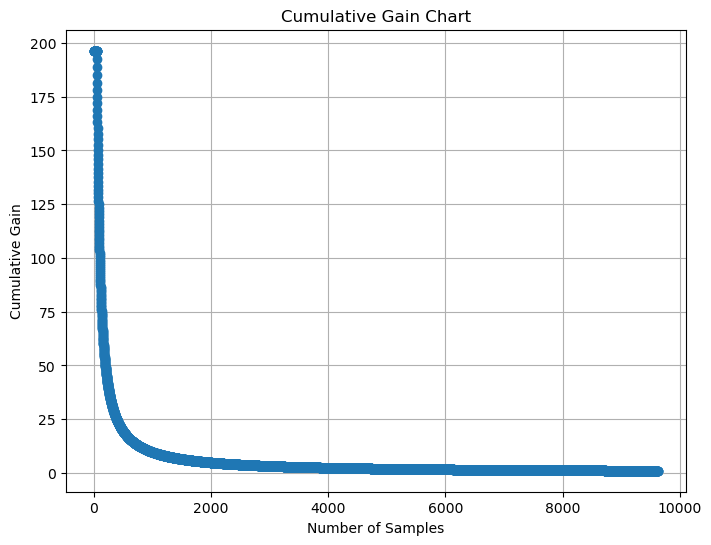

AUC: 60244.522132305465


In [166]:
from sklearn.metrics import auc

# Sort the data by predicted probabilities
prob_df = prob_df.sort_values(by='Predicted Probability', ascending=False)

# Calculate cumulative gains
total_samples = len(prob_df)
prob_df['Cumulative Samples'] = range(1, total_samples + 1)
prob_df['Cumulative Positives'] = prob_df['Actual'].cumsum()
prob_df['Cumulative Gain'] = (prob_df['Cumulative Positives'] / prob_df['Cumulative Samples']) / (sum(prob_df['Actual']) / total_samples)

# Create a lift chart
plt.figure(figsize=(8, 6))
plt.plot(prob_df['Cumulative Samples'], prob_df['Cumulative Gain'], marker='o', linestyle='-')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.grid()
plt.show()

# Calculate the area under the cumulative gain curve (AUC)
auc_score = auc(prob_df['Cumulative Samples'], prob_df['Cumulative Gain'])
print(f'AUC: {auc_score}')


# Random Forest

In [186]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

feature_columns = ['is_weekend','is_business_hours','Junction_1','Junction_2','Junction_3','Junction_4']

X_train1 = df_train[feature_columns]
y_train1= df_train['congested']

X_test1 = df_train[feature_columns]
y_test1= df_train['congested']


rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


rf_classifier.fit(X_train1, y_train1)


y_pred1 = rf_classifier.predict(X_test1)


accuracy = accuracy_score(y_test1, y_pred1)
classification_rep = classification_report(y_test1, y_pred1)
confusion_mat = confusion_matrix(y_test1, y_pred1)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', confusion_mat)


Accuracy: 0.9934538653366584
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47805
           1       0.00      0.00      0.00       315

    accuracy                           0.99     48120
   macro avg       0.50      0.50      0.50     48120
weighted avg       0.99      0.99      0.99     48120

Confusion Matrix:
 [[47805     0]
 [  315     0]]


C:\Users\91761\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91761\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91761\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


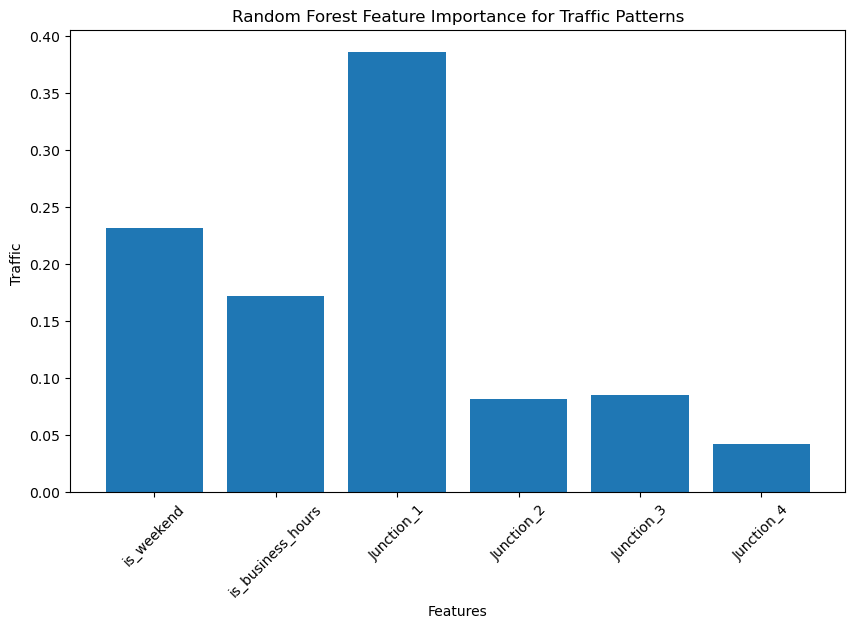

In [189]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_columns)
plt.xlabel('Features')
plt.ylabel('Traffic ')
plt.title('Random Forest Feature Importance for Traffic Patterns')
plt.xticks(rotation=45)
plt.show()


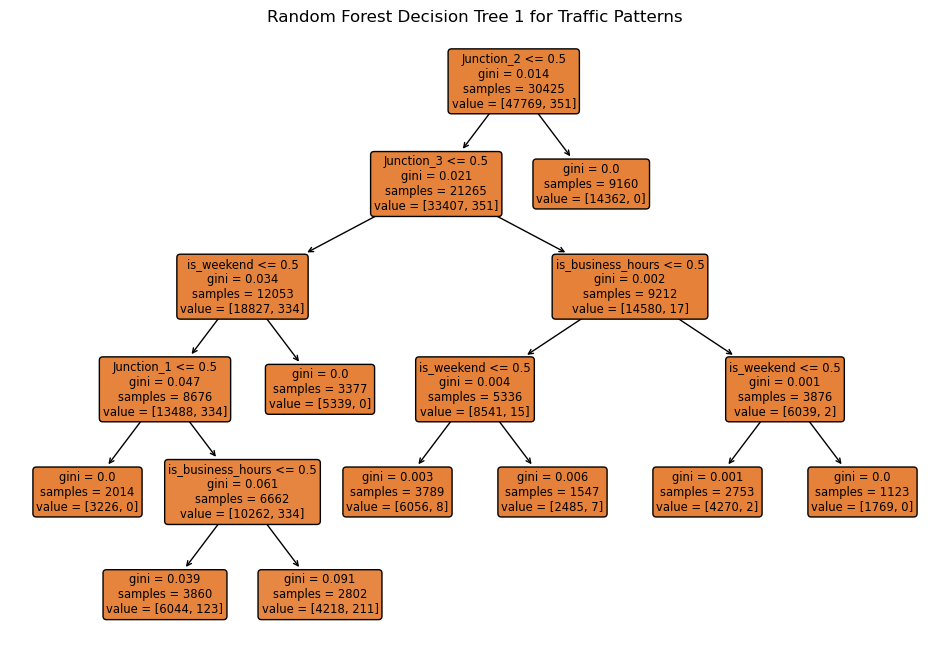

In [192]:
from sklearn.tree import plot_tree


tree_index = 0

plt.figure(figsize=(12, 8))
plot_tree(rf_classifier.estimators_[tree_index], feature_names=feature_columns, filled=True, rounded=True)
plt.title(f'Random Forest Decision Tree {tree_index + 1} for Traffic Patterns')
plt.show()


In [193]:
y_pred1 = rf_classifier.predict(df_train[feature_columns])

In [194]:
y_pred1 = rf_classifier.predict(df_train[feature_columns])

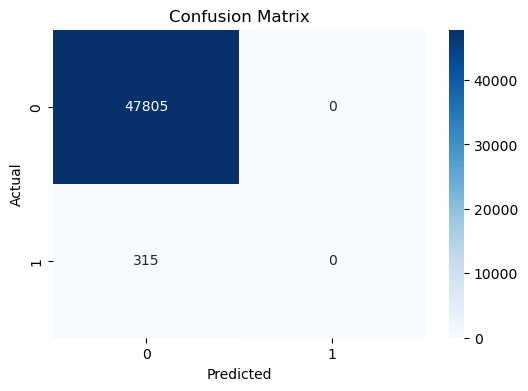

In [196]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
confusion = confusion_matrix(df_train['congested'], y_pred1)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
